# Image Processing CookBook
## Chapter 05
### Author: Sandipan Dey

### Image Alignment with ECC algorithm

992 610


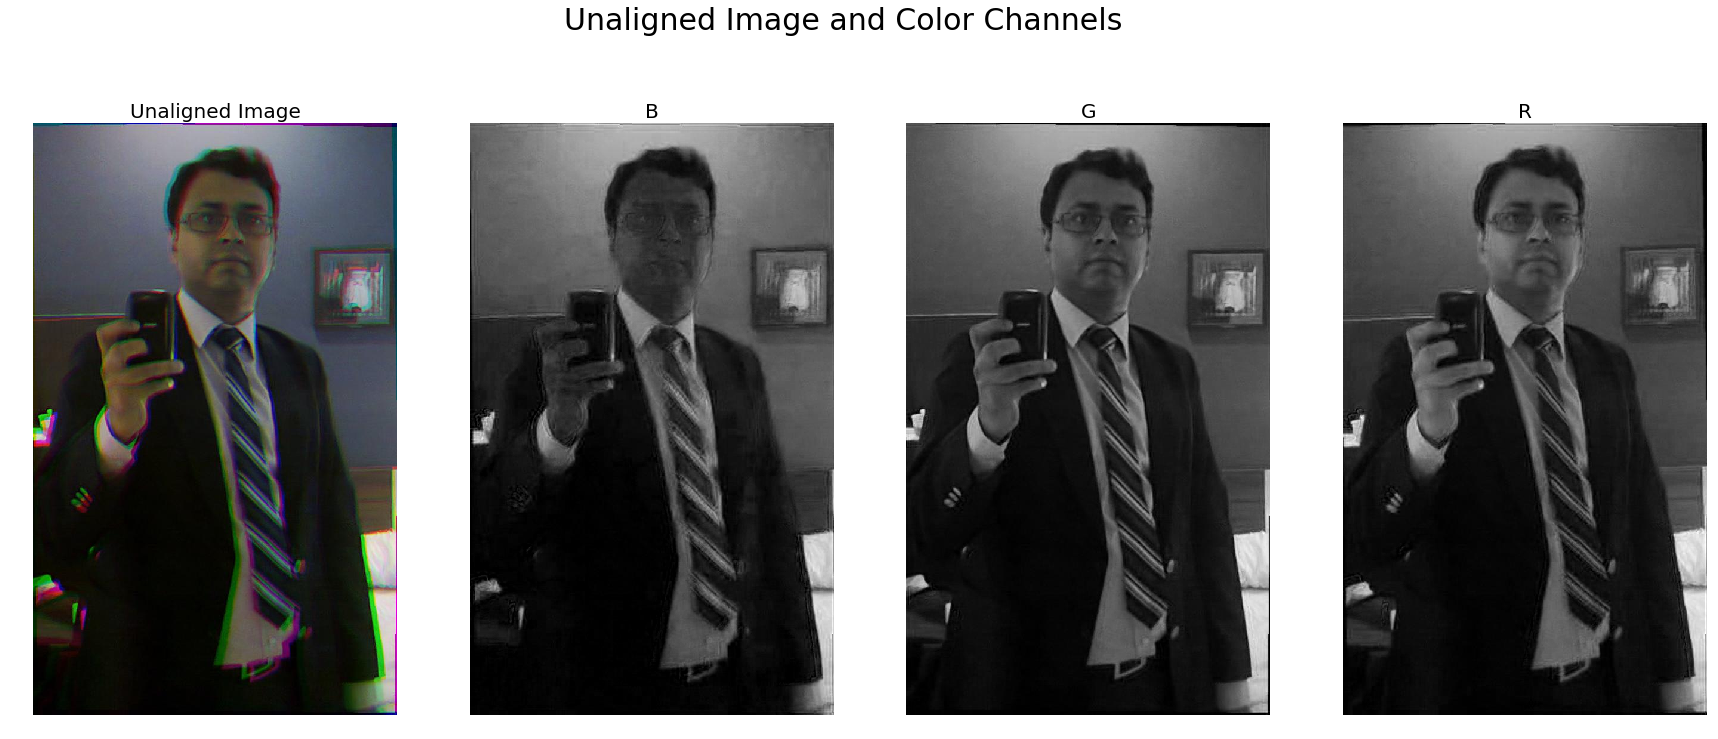

Processing Channel B...
[[ 9.9852240e-01 -7.3300595e-03  8.7293777e+00]
 [ 1.3443469e-02  9.9930155e-01 -3.7745864e+00]
 [-3.5765074e-06  2.5245824e-06  1.0000000e+00]]
Processing Channel G...
[[ 1.0092515e+00 -2.7040454e-02  8.6985931e+00]
 [ 2.6736395e-02  9.8989981e-01 -5.0035219e+00]
 [-6.7387623e-07  5.9878818e-07  1.0000000e+00]]


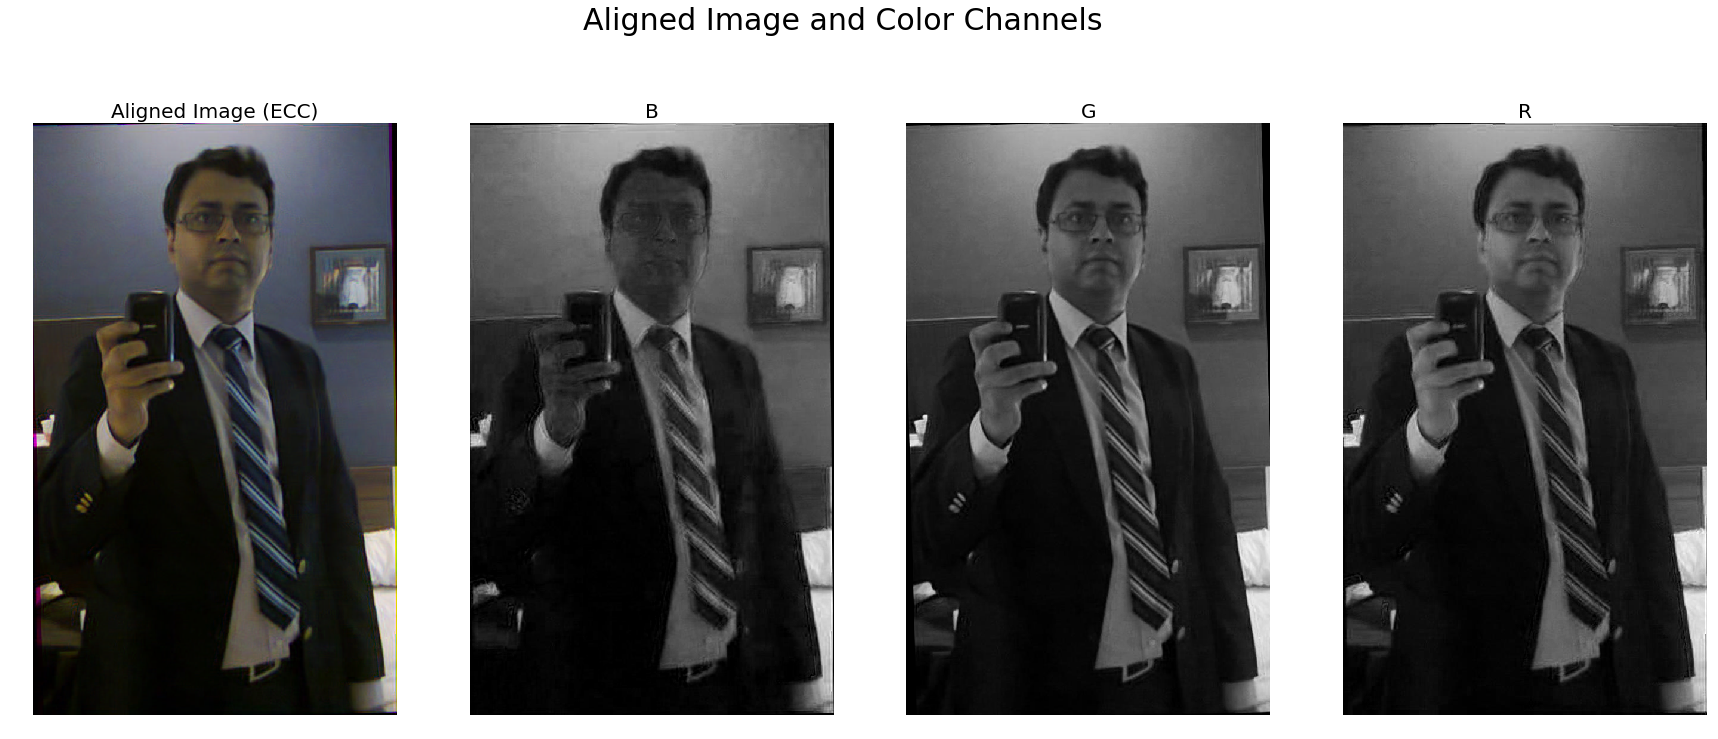

True

In [2]:
% matplotlib inline
import cv2
import numpy as np
import matplotlib.pylab as plt
 
def compute_gradient(im) :
    grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
    grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad

im_unaligned =  cv2.imread("images/me_unaligned.jpg")

height, width = im_unaligned.shape[:2]
print(height, width)

channels = ['B', 'G', 'R']

plt.figure(figsize=(30,12))
plt.gray()
plt.subplot(1,4,1), plt.imshow(cv2.cvtColor(im_unaligned, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Unaligned Image', size=20)
for i in range(3):
    plt.subplot(1,4,i+2), plt.imshow(im_unaligned[...,i]), plt.axis('off'), plt.title(channels[i], size=20)
plt.suptitle('Unaligned Image and Color Channels', size=30)
plt.show()

im_aligned = np.zeros_like(im_unaligned)

# The blue and green channels will be aligned to the red channel.
# So copy the red channel
im_aligned[...,2] = im_unaligned[...,2]

# Define motion model
warp_mode = cv2.MOTION_HOMOGRAPHY

# Set the warp matrix to identity.
warp_matrix = np.eye(3, 3, dtype=np.float32) if warp_mode == cv2.MOTION_HOMOGRAPHY else np.eye(2, 3, dtype=np.float32)

# Set the stopping criteria for the algorithm.
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)

im_grad2 = compute_gradient(im_unaligned[...,2])

# Warp the blue and green channels to the red channel
for i in range(2) :
    print('Processing Channel {}...'.format(channels[i]))
    (cc, warp_matrix) = cv2.findTransformECC (im_grad2, compute_gradient(im_unaligned[...,i]),warp_matrix, warp_mode, criteria)

    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use Perspective warp when the transformation is a Homography
        im_aligned[...,i] = cv2.warpPerspective (im_unaligned[...,i], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else :
        # Use Affine warp when the transformation is not a Homography
        im_aligned[...,i] = cv2.warpAffine(im_unaligned[...,i], warp_matrix, (width, height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
    print (warp_matrix)
    
channels = ['B', 'G', 'R']
plt.figure(figsize=(30,12))
plt.subplot(1,4,1), plt.imshow(cv2.cvtColor(im_aligned, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Aligned Image (ECC)', size=20)
for i in range(3):
    plt.subplot(1,4,i+2), plt.imshow(im_aligned[...,i]), plt.axis('off'), plt.title(channels[i], size=20)
plt.suptitle('Aligned Image and Color Channels', size=30)
plt.show()

cv2.imwrite("images/me_aligned.jpg", im_aligned)

### Feature-based image alignment with ORB

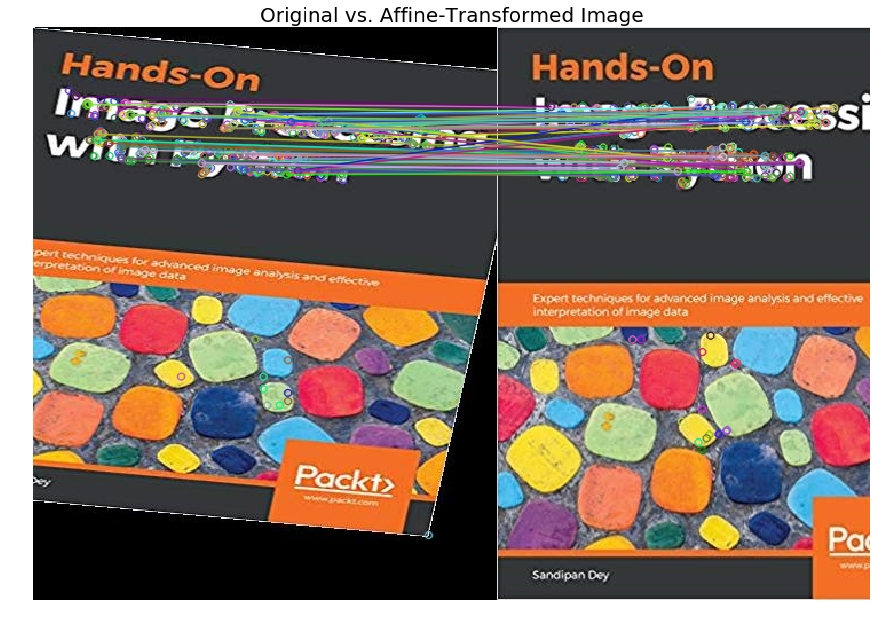


 Estimated homography : 
 [[ 8.90132747e-01  1.74068778e-01  4.52121708e+00]
 [-1.11327534e-01  1.17723294e+00  2.11909068e+00]
 [-1.18280055e-05 -6.27770905e-05  1.00000000e+00]]


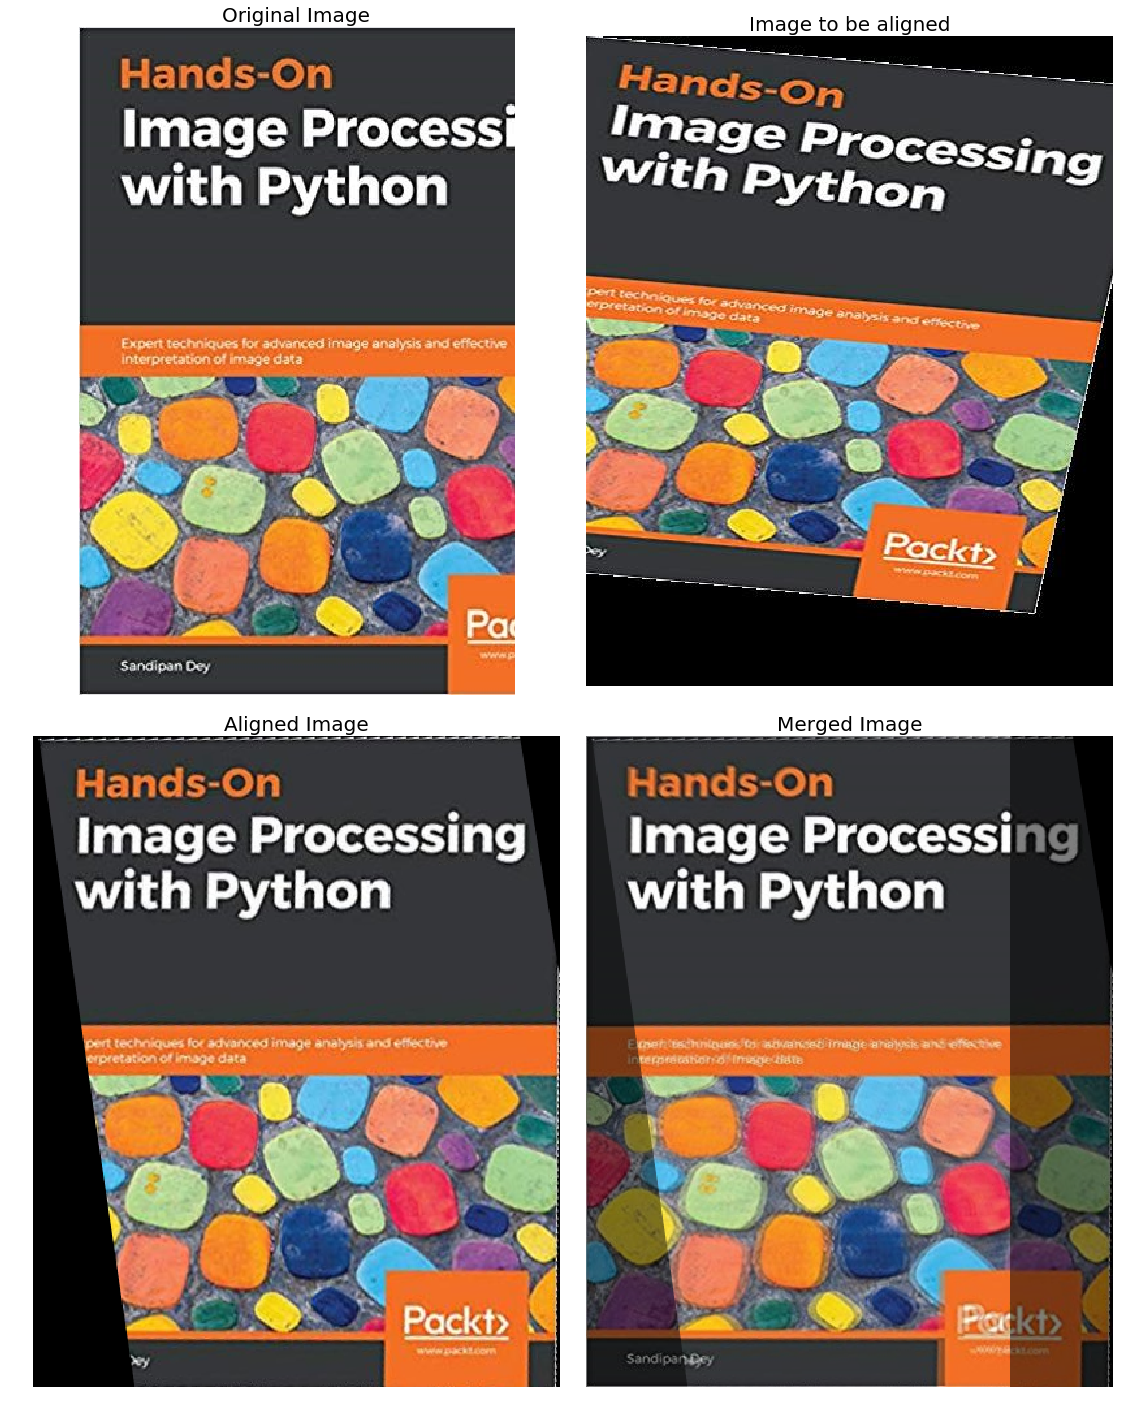

In [14]:
# https://stackoverflow.com/questions/41692063/what-is-the-difference-between-image-registration-and-image-alignment

import cv2
import numpy as np
import matplotlib.pylab as plt
 
 
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

# reference image
im_ref = cv2.imread('images/book_half.jpg') 
# images to be aligned
im1 = cv2.imread('images/book_affine.jpg') 

# Convert images to grayscale
im_ref_g = cv2.cvtColor(im_ref, cv2.COLOR_RGB2GRAY)
im1_g = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)

# Detect ORB features and compute descriptors.
orb = cv2.ORB_create(MAX_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1_g, None)
keypoints_ref, descriptors_ref = orb.detectAndCompute(im_ref_g, None)
   
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches1 = matcher.match(descriptors1, descriptors_ref, None)
   
# Sort matches by score
matches1.sort(key=lambda x: x.distance, reverse=False)
# Remove not so good matches
num_good_matches = int(len(matches1) * GOOD_MATCH_PERCENT)
matches1 = matches1[:num_good_matches]
 
# Draw top matches
im_matches = cv2.drawMatches(im1, keypoints1, im_ref, keypoints_ref, matches1, None)
plt.figure(figsize=(15,12))
plt.imshow(cv2.cvtColor(im_matches, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Original vs. Affine-Transformed Image', size=20)
plt.show()

def compute_alignment(matches, im, keypoints, keypoints_ref):
    # Extract location of good matches
    points = np.zeros((len(matches), 2), dtype=np.float32)
    points_ref = np.zeros((len(matches), 2), dtype=np.float32) 
    for i, match in enumerate(matches):
        points[i, :] = keypoints[match.queryIdx].pt
        points_ref[i, :] = keypoints_ref[match.trainIdx].pt   
    # Find homography
    h, mask = cv2.findHomography(points, points_ref, cv2.RANSAC)
    # Use homography
    height, width, channels = im.shape
    im_ref_reg = cv2.warpPerspective(im, h, (width, height))
    # Print estimated homography
    print("\n Estimated homography : \n",  h)
    return im_ref_reg

im_reg = compute_alignment(matches1, im1, keypoints1, keypoints_ref)
#print(im_ref.shape, im_reg.shape)
im_ref1 = np.zeros_like(im_reg)
im_ref1[:im_ref.shape[0],:im_ref.shape[1],:] = im_ref
im_merged = cv2.addWeighted(im_ref1, 0.5, im_reg, 0.5, 0)

plt.figure(figsize=(15,20))
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0.05)
plt.subplot(221), plt.imshow(cv2.cvtColor(im_ref, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Original Image', size=20)
plt.subplot(222), plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Image to be aligned', size=20)
plt.subplot(223), plt.imshow(cv2.cvtColor(im_reg, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Aligned Image', size=20)
plt.subplot(224), plt.imshow(cv2.cvtColor(im_merged, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Merged Image', size=20)
plt.show()